# In this notebook we will create the network that do double regression from word_embedding to type_embedding &  hyperbolic_embedding

### Import

In [17]:
#word2vec imports
from gensim.models import Word2Vec

#hyperbolic imports
import torch
import tensorflow as tf
from numpy.linalg import norm
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist


# sparQL imports
from SPARQLWrapper import SPARQLWrapper, JSON

# ML imports
import keras
from keras.models import Model
from keras.layers import *    
from keras import backend as K
from keras.callbacks import EarlyStopping

# Confusion Matrix imports
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#utility imports
import os
import warnings
import random
import itertools
from operator import itemgetter
from collections import Counter
from IPython.display import clear_output

#data analysis imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score

# FUNCTIONS
from mixed_regression_functions import *

warnings.filterwarnings('ignore')
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


### Load emdeddings

In [18]:
# PATH
WORD_EMBEDDING_PATH = "./datasets/text_s400_w5"
HYPERBOLIC_EMBEDDING_PATH = "./datasets/10dim_hyperbolic_embedding.pth"
TYPE_EMBEDDING_PATH = "./datasets/t2v.bin"

In [19]:
word_embedding = Word2Vec.load(WORD_EMBEDDING_PATH)
hyperbolic_embedding = torch.load(HYPERBOLIC_EMBEDDING_PATH)
type_embedding = Word2Vec.load(TYPE_EMBEDDING_PATH)

### Search class and entities/words for regression

In [20]:
types = ['dbo:Mammal'
         , 'dbo:Planet'
         , 'dbo:Company'
         , 'dbo:City'
         , 'dbo:Plant'
         , 'dbo:AnatomicalStructure'
         , 'dbo:Food'
         , 'dbo:Aircraft'
         , 'dbo:Automobile'
#          , 'dbo:Bird'
#          , 'dbo:Fish'
#          , 'dbo:Software'
#          , 'dbo:Politician'
        ]
classes = [x.replace('dbo:', '') for x in types]

In [21]:
words = []
for t in types:
    w = get_from_class(t)
    words.append(w) 

### Build input and output vectors 

#### filter words

In [22]:
good_words = [[] for i in range(len(words))]
i = 0
j = 0
for type_index, type_words in enumerate(words):
    for word in type_words:
        try:
            word_embedding.wv[word]
            good_words[type_index].append(word)
        except:
            i += 1

        if word.lower() != word:
            j += 1
            try:
                word_embedding.wv[word.lower()]
                good_words[type_index].append(word.lower())
            except:
                i += 1
            
print('{} found on {}'.format(sum([len(x) for x in words]) - i + j, sum([len(x) for x in words])))

all_words = [item for sublist in good_words for item in sublist] 

data = {}
for t, type_words in zip(types, good_words):
    data.update({t.replace('dbo:', '') : [m for m in type_words]})

for k, w in zip(data.keys(), data):
    print('{} {}'.format(len(data[k]), k))   

14266 found on 83203
1079 Mammal
138 Planet
2514 Company
3828 City
3235 Plant
1062 AnatomicalStructure
2025 Food
106 Aircraft
279 Automobile


In [23]:
X_train,\
X_test,\
y_hyp_train,\
y_hyp_test,\
y_t2v_train,\
y_t2v_test,\
labels_train,\
labels_test = get_datasets(data,
                             word_embedding,
                             hyperbolic_embedding,
                             type_embedding,
                             test_size=0.1)

12839 train input 
12839 t2v_train_output
12839 hyper_train_output
1427 test input 
1427 t2v_test_output
1427 hyper_test_output


In [31]:
silhouette_score(X_train, labels_train, 'cosine')

0.054618303

## Regression Networks

In [24]:
def make_network(input_dimension = 0):
    if input_dimension == 0:
        input_dimension = word_embedding.wv.vector_size
    type_embedding_dimension = type_embedding.wv.vector_size
    hyper_embedding_dimension = 10


    mixed_layer_neurons = 100

    inp = Input(shape=(input_dimension, ))

    mixed = Dense(mixed_layer_neurons, activation = "relu")(inp)
    mixed = Dense(mixed_layer_neurons, activation = "relu")(mixed)
    
    hyperbolic_embedding_layer = Dense(hyper_embedding_dimension, name='Hyper')(mixed)
    
    type_embedding_layer = Dense(type_embedding_dimension, name='T2V')(mixed)
    
    return inp, mixed, hyperbolic_embedding_layer, type_embedding_layer

In [9]:
def mean_squared_error(y_true, y_pred):
    return  K.mean(K.square(y_pred - y_true), axis = 1)

In [25]:
def hyperbolic_loss(y_true, y_pred):    
    num = 2 * tf.norm(y_true - y_pred, axis = 1)
    densx = (1 - tf.norm(y_pred, axis = 1))
    dendx = (1 - tf.norm(y_true, axis = 1))
    denom = densx * dendx
    clipped = tf.clip_by_value(denom,
                               clip_value_min=0.0000001,
                               clip_value_max=10000000)
    frac = num/clipped
    acos = tf.math.acosh(1  + frac)
    acos = tf.diag(acos)
    ret = K.mean(K.mean(acos, axis = -1))
    return ret

In [11]:
def poincare_norm(vec):
    return 2 * tf.math.atanh(tf.norm(vec, axis = 1) ** 2)

### Mixed Model

In [26]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network()

early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
mixed_model.compile(optimizer='adam', loss=['cosine_proximity', hyperbolic_loss])
mixed_history = mixed_model.fit(X_train
                                , [y_t2v_train, y_hyp_train] 
                                , epochs = 30
                                , batch_size = 16
                                , validation_split=0.2
                                , shuffle = True
                                , callbacks = [early_stop]
               )

Train on 10271 samples, validate on 2568 samples
Epoch 1/30
10271/10271 [==============================] - 2s 220us/step - loss: -0.5905 - T2V_loss: -0.8361 - Hyper_loss: 0.2456 - val_loss: -0.6586 - val_T2V_loss: -0.8994 - val_Hyper_loss: 0.2408
Epoch 2/30
10271/10271 [==============================] - 2s 159us/step - loss: -0.6742 - T2V_loss: -0.9122 - Hyper_loss: 0.2381 - val_loss: -0.6619 - val_T2V_loss: -0.9023 - val_Hyper_loss: 0.2404
Epoch 3/30
10271/10271 [==============================] - 2s 163us/step - loss: -0.6918 - T2V_loss: -0.9301 - Hyper_loss: 0.2382 - val_loss: -0.6672 - val_T2V_loss: -0.9054 - val_Hyper_loss: 0.2382
Epoch 4/30
10271/10271 [==============================] - 2s 163us/step - loss: -0.7089 - T2V_loss: -0.9447 - Hyper_loss: 0.2358 - val_loss: -0.6654 - val_T2V_loss: -0.9036 - val_Hyper_loss: 0.2382
Epoch 5/30
10271/10271 [==============================] - 2s 150us/step - loss: -0.7199 - T2V_loss: -0.9559 - Hyper_loss: 0.2361 - val_loss: -0.6635 - val_T2V_

### T2V regression model

In [27]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network()

early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

t2v_model = Model(input=inp, output=type_embedding_layer)
t2v_model.compile(optimizer='adam', loss='cosine_proximity')
t2v_history = t2v_model.fit(X_train
                            , y_t2v_train 
                            , epochs = 30
                            , batch_size = 16
                            , validation_split=0.2
                            , shuffle = True
                            , callbacks = [early_stop]
             )

Train on 10271 samples, validate on 2568 samples
Epoch 1/30
10271/10271 [==============================] - 2s 215us/step - loss: -0.8453 - val_loss: -0.9005
Epoch 2/30
10271/10271 [==============================] - 2s 165us/step - loss: -0.9147 - val_loss: -0.9057
Epoch 3/30
10271/10271 [==============================] - 2s 146us/step - loss: -0.9325 - val_loss: -0.9060
Epoch 4/30
10271/10271 [==============================] - 1s 142us/step - loss: -0.9458 - val_loss: -0.9053
Epoch 5/30
10271/10271 [==============================] - 2s 150us/step - loss: -0.9572 - val_loss: -0.9047
Epoch 6/30
10271/10271 [==============================] - 2s 195us/step - loss: -0.9644 - val_loss: -0.8981
Epoch 7/30
10271/10271 [==============================] - 2s 181us/step - loss: -0.9700 - val_loss: -0.8982
Epoch 8/30
10271/10271 [==============================] - 2s 153us/step - loss: -0.9728 - val_loss: -0.8952
Epoch 9/30
10271/10271 [==============================] - 2s 148us/step - loss: -0.9765

### Hyperbolic regression model

In [28]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network()

hyper_model = Model(input=inp, output=hyperbolic_embedding_layer)
hyper_model.compile(optimizer='adam', loss=hyperbolic_loss)
early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

hyper_history = hyper_model.fit(X_train
                                , y_hyp_train
                                , epochs=30
                                , batch_size = 16
                                , validation_split=0.1
                                , shuffle=True
                                , callbacks=[early_stop]
               )

Train on 11555 samples, validate on 1284 samples
Epoch 1/30
11555/11555 [==============================] - 2s 216us/step - loss: 0.2412 - val_loss: 0.2415
Epoch 2/30
11555/11555 [==============================] - 2s 139us/step - loss: 0.2387 - val_loss: 0.2449
Epoch 3/30
11555/11555 [==============================] - 2s 139us/step - loss: 0.2386 - val_loss: 0.2386
Epoch 4/30
11555/11555 [==============================] - 2s 150us/step - loss: 0.2363 - val_loss: 0.2383
Epoch 5/30
11555/11555 [==============================] - 2s 196us/step - loss: 0.2372 - val_loss: 0.2374
Epoch 6/30
11555/11555 [==============================] - 2s 155us/step - loss: 0.2356 - val_loss: 0.2366
Epoch 7/30
11555/11555 [==============================] - 2s 152us/step - loss: 0.2340 - val_loss: 0.2358
Epoch 8/30
11555/11555 [==============================] - 2s 142us/step - loss: 0.2332 - val_loss: 0.2351
Epoch 9/30
11555/11555 [==============================] - 2s 167us/step - loss: 0.2327 - val_loss: 0.23

## Predict Evaluation

## All evaluation & Matrices

In [29]:
models = {'mixed':mixed_model, 't2v':t2v_model, 'hyper':hyper_model}
embeddings = {'t2v':type_embedding, 'hyper': hyperbolic_embedding}

90%


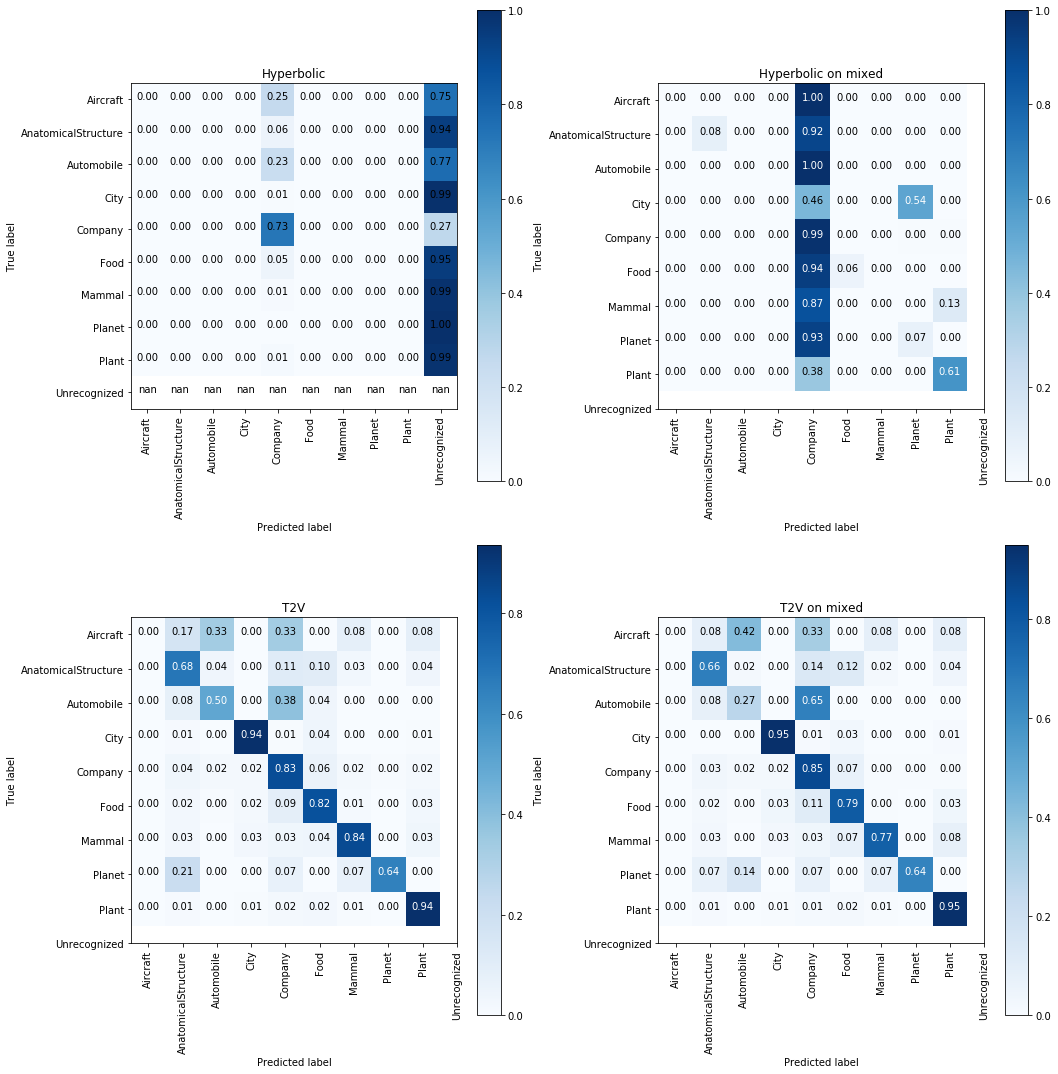

In [30]:
plot_all(X_test, labels_test, models, embeddings, types, 10)

90%


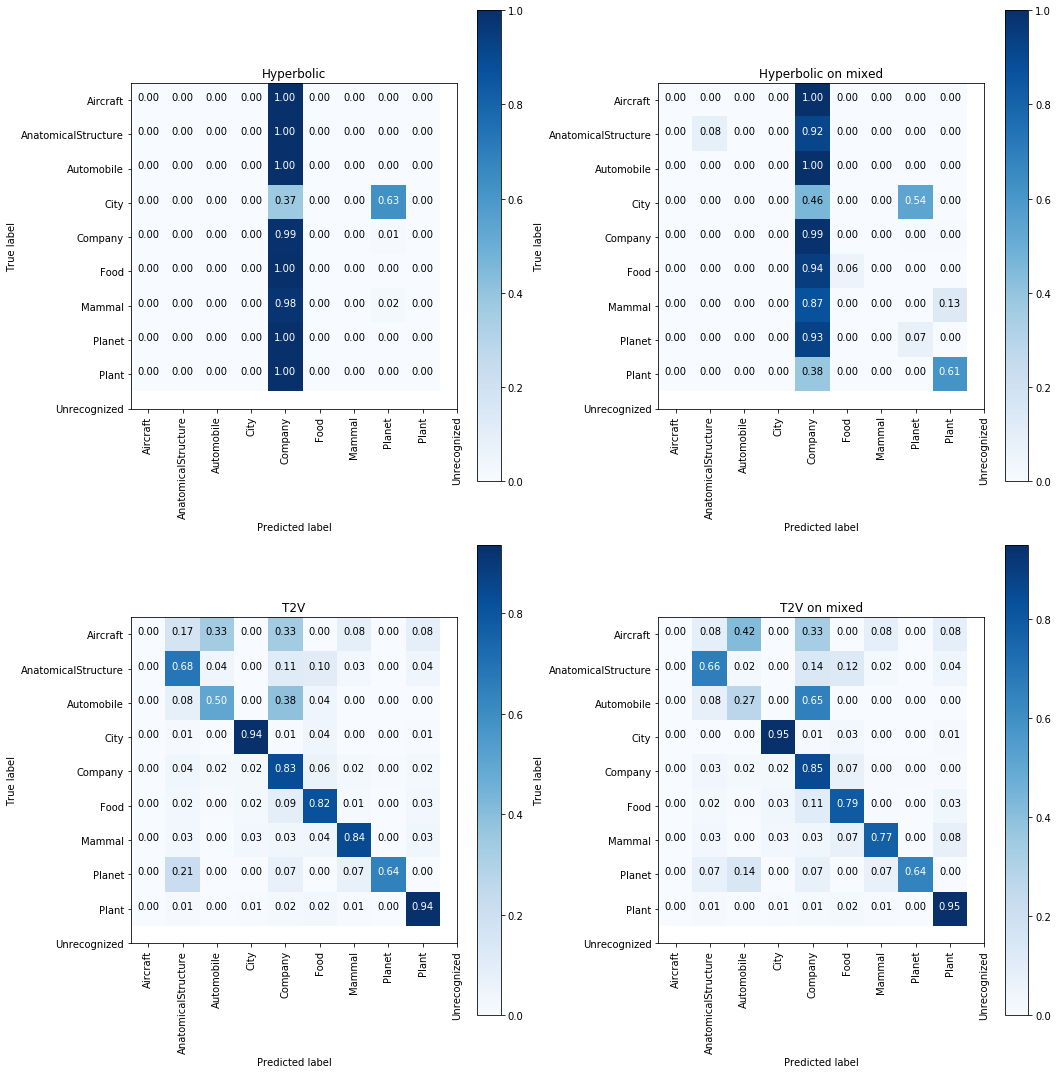

In [31]:
plot_all(X_test, labels_test, models, embeddings, types, 'all')

In [ ]:
# plot_all(X_test, labels_test, mixed_model, hyper_model, t2v_model, types, 50)

In [ ]:
plot_loss(mixed_history)

In [ ]:
plot_loss(t2v_history)

In [ ]:
plot_loss(hyper_history)

## Quality Tests

### Single word prediction

In [36]:
words = ['limousine', 'Batmobile', 'Fiorino'
         ,'pizza', 'meatballs', 'juice'
         ,'pine', 'sunflower', 'stinkhorn'
         ,'Rome', 'Germany', 'Italy'
         ,'dog', 'cat', 'crab'
         ,'Olivetti', 'Yahoo', 'Harvard'
         ,'heart', 'carotid', 'tail'
         ,'Moon', 'sun', 'star']

for word in words:
#     print('Predictions for {}'.format(word))
    if word in all_words:
        print('Predictions for {} which is in train or in test dataset'.format(word))
    else:
        print('Predictions for {} which is NOT in train and NOT in test dataset'.format(word))
        
    vector = word_embedding[word]
    pred = mixed_model.predict(np.array([vector]))
    t2v_pred = pred[0][0]
    t2v_neigh = find_neighbours(vector=t2v_pred,
                               model=type_embedding,
                               mode='t2v',
                               topn=len(types))
                               
    t2v_sim = t2v_neigh[0]
    t2v_label = t2v_neigh[1]
    
    t2v_sim = [round(x, 4) for x in t2v_sim]
    
    hyper_pred = pred[1][0]
    hyper_neigh = find_neighbours(vector=hyper_pred,
                                 model=hyperbolic_embedding, 
                                 mode='hyper',
                                 topn=len(types))
    
    
    hyper_sim = hyper_neigh[0]
    hyper_label = hyper_neigh[1]
    
    hyper_sim = [round(x, 4) for x in hyper_sim]
    
    
    mean_cluster_dist = distance_from_cluster(vector, train_vector_types_dict)
    classes = [x.replace('dbo:', '') for x in types]
    mcd = list(zip(mean_cluster_dist, classes))
    mcd = sorted([[y, round(x, 4)] for x, y in mcd], key=itemgetter(1), reverse=True)

    mcd_label = [y for y, x in mcd]
    mcd_sim = [x for y, x in mcd]
    
    n = 9
    
    print('-----------------------------------------------------------------------------------------------------------')
    print('Mean Cluster Similarity            |T2V PREDICTION              cos-sim|HYPER PREDICTION            hyper-d')
    print('-----------------------------------|-----------------------------------|-----------------------------------')
    for x, y, w, z, ml, ms in zip(hyper_label[:n], hyper_sim[:n], t2v_label[:n], t2v_sim[:n], mcd_label[:n], mcd_sim[:n]):
        print('{:25} {:9.4f}|{:25} {:9.4f}|{:25} {:9.4f}'.format(ml, ms, w, z, x, y)) 
    print('-----------------------------------------------------------------------------------------------------------')

Predictions for limousine which is in train or in test dataset
-----------------------------------------------------------------------------------------------------------
Mean Cluster Similarity            |T2V PREDICTION              cos-sim|HYPER PREDICTION            hyper-d
-----------------------------------|-----------------------------------|-----------------------------------
Automobile                   0.2566|Company                      0.9252|Thing                        0.4702
Aircraft                     0.2214|Automobile                   0.8218|Library                      0.8800
Company                      0.1662|AutomobileEngine             0.6351|College                      1.0177
Food                         0.1529|InformationAppliance         0.6185|EducationalInstitution       1.0290
Mammal                       0.1241|Motorcycle                   0.6084|University                   1.0322
AnatomicalStructure          0.1241|Software                     0.6040|S

### Composite word prediction

In [ ]:
words_to_sum = [['robot', 'cat']]

for word in words_to_sum:
    compound_word = word[0] + ' + ' + word[1]
    print('Predictions for {}'.format(compound_word))
    for w in word:
        if w in all_words:
            print('{} is in train or in test dataset'.format(w))
        else:
            print('{} is NOT in train and NOT in test dataset'.format(w))
        
    vector = word_embedding[word[1]] + word_embedding[word[1]]
    pred = mixed_model.predict(np.array([vector]))
    t2v_pred = pred[0][0]
    t2v_neigh = find_neighbours(vector=t2v_pred,
                               model=type_embedding,
                               mode='t2v')
    t2v_sim = t2v_neigh[0]
    t2v_label = t2v_neigh[1]
    
    t2v_sim = [round(x, 4) for x in t2v_sim]
    
    hyper_pred = pred[1][0]
    hyper_neigh = find_neighbours(vector=hyper_pred,
                                 model=hyperbolic_embedding, 
                                 mode='hyper')
    
    
    hyper_sim = hyper_neigh[0]
    hyper_label = hyper_neigh[1]
    
    hyper_sim = [round(x, 4) for x in hyper_sim]
    
    mean_cluster_dist = distance_from_cluster(vec, train_vector_types_dict)
    classes = [x.replace('dbo:', '') for x in types]
    mcd = list(zip(mean_cluster_dist, classes))
    mcd = sorted([[y, round(x, 4)] for x, y in show], key=itemgetter(1), reverse=True)
    
    print('-------------------------------------------------------------')
    print('HYPER PREDICTION       hyper-d|T2V PREDICTION         cos-sim')
    print('------------------------------|------------------------------')
    for x, y, w, z in zip(hyper_label, hyper_sim, t2v_label, t2v_sim):
        print('{:20} {:9.4f}|{:20} {:9.4f}'.format(x, y, w, z)) 
    print('-------------------------------------------------------------')

## Analysis between word and type-word clusters

In [35]:
train_vector_types_dict = {k: [] for k in classes}
for vec, clas in zip(X_train, labels_train):
    train_vector_types_dict[clas].append(vec)

## Random Forest on Input Data clustered by dbo:Type

In [28]:
def random_forest_classifier(X_train, X_test, Y_train, Y_test, classes):
    clf = RandomForestClassifier(n_estimators=200, max_depth=15)
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    cm = confusion_matrix(y_pred=pred, y_true=Y_test)
    plt.figure(figsize=(15,15))
    classes = [x.replace('dbo:', '') for x in types]
    classes = classes + ['Unrecognized']
    classes = sorted(classes)
    
    print(accuracy_score(y_pred=pred, y_true=Y_test))
    plot_confusion_matrix(cm, classes)

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('./{}.png'.format(title))

## Middle Out Analysis

### make an encoder from mixed network 

In [45]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network()

mixed_encoder = Model(input=inp, output=mixed)

mixed_encoder.set_weights(mixed_model.get_weights()[0:10])

In [144]:
encoded_train = mixed_encoder.predict(X_train)
encoded_test = mixed_encoder.predict(X_test)

In [47]:
random_forest_classifier(X_train, X_test, labels_train, labels_test, types)

KeyboardInterrupt: 

0.849334267694464


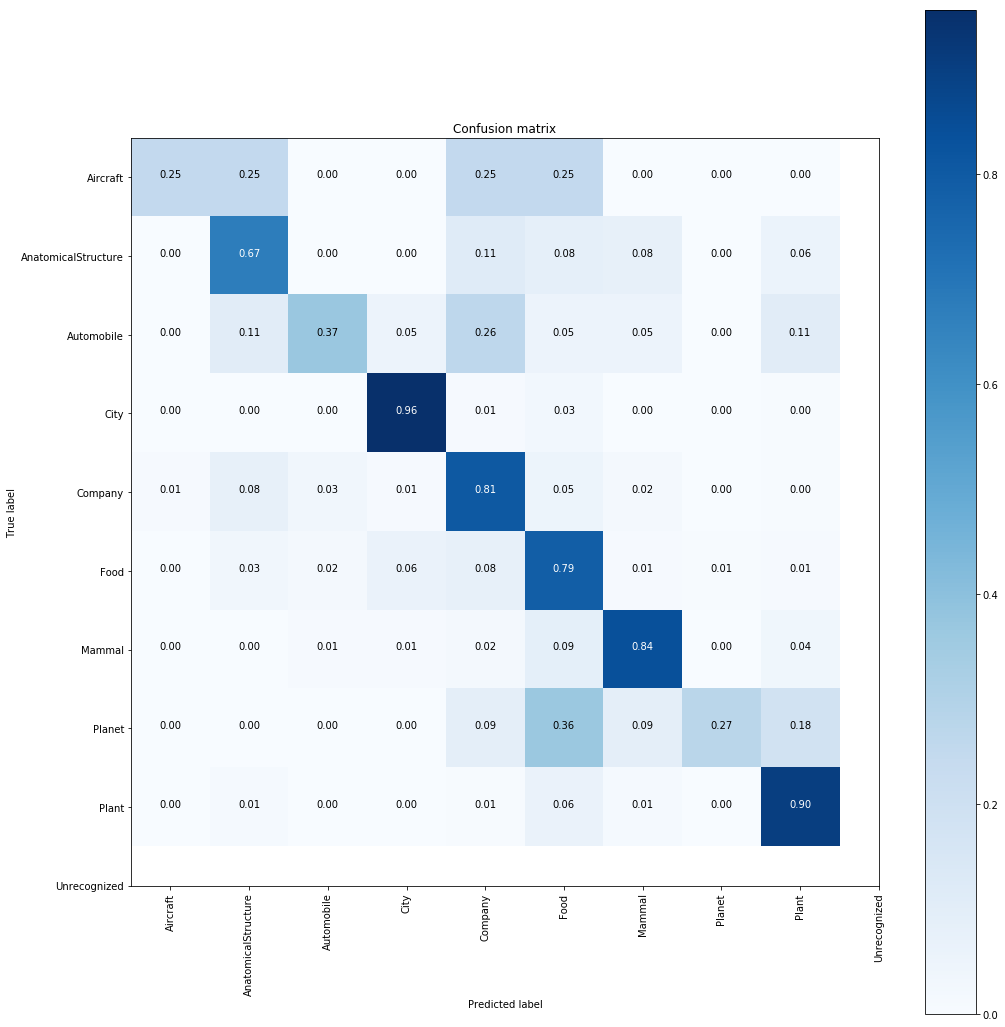

In [48]:
random_forest_classifier(encoded_train, encoded_test, labels_train, labels_test, types)

In [49]:
silhouette_score(encoded_train, labels_train, 'cosine')

0.7521143

### train mixed with encoded input

In [50]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(input_dimension = 100)

mo_mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
mo_mixed_model.compile(optimizer='adam', loss=['cosine_proximity', 'mse'])
mo_mixed_history = mo_mixed_model.fit(encoded_train
                                      , [y_t2v_train, y_hyp_train]
                                      , epochs = 10
                                      , batch_size = 16
                                      , validation_split=0.2
                                      , shuffle = True
#                                 , callbacks = [early_stop]
               )

Train on 10271 samples, validate on 2568 samples
Epoch 1/10
10271/10271 [==============================] - 3s 318us/step - loss: -0.9424 - T2V_loss: -0.9542 - Hyper_loss: 0.0118 - val_loss: -0.8776 - val_T2V_loss: -0.8939 - val_Hyper_loss: 0.0164
Epoch 2/10
10271/10271 [==============================] - 3s 254us/step - loss: -0.9824 - T2V_loss: -0.9858 - Hyper_loss: 0.0034 - val_loss: -0.8767 - val_T2V_loss: -0.8928 - val_Hyper_loss: 0.0161
Epoch 3/10
10271/10271 [==============================] - 3s 253us/step - loss: -0.9845 - T2V_loss: -0.9874 - Hyper_loss: 0.0029 - val_loss: -0.8755 - val_T2V_loss: -0.8919 - val_Hyper_loss: 0.0164
Epoch 4/10
10271/10271 [==============================] - 3s 255us/step - loss: -0.9854 - T2V_loss: -0.9881 - Hyper_loss: 0.0028 - val_loss: -0.8741 - val_T2V_loss: -0.8904 - val_Hyper_loss: 0.0163
Epoch 5/10
10271/10271 [==============================] - 2s 238us/step - loss: -0.9861 - T2V_loss: -0.9887 - Hyper_loss: 0.0026 - val_loss: -0.8754 - val_T2V_

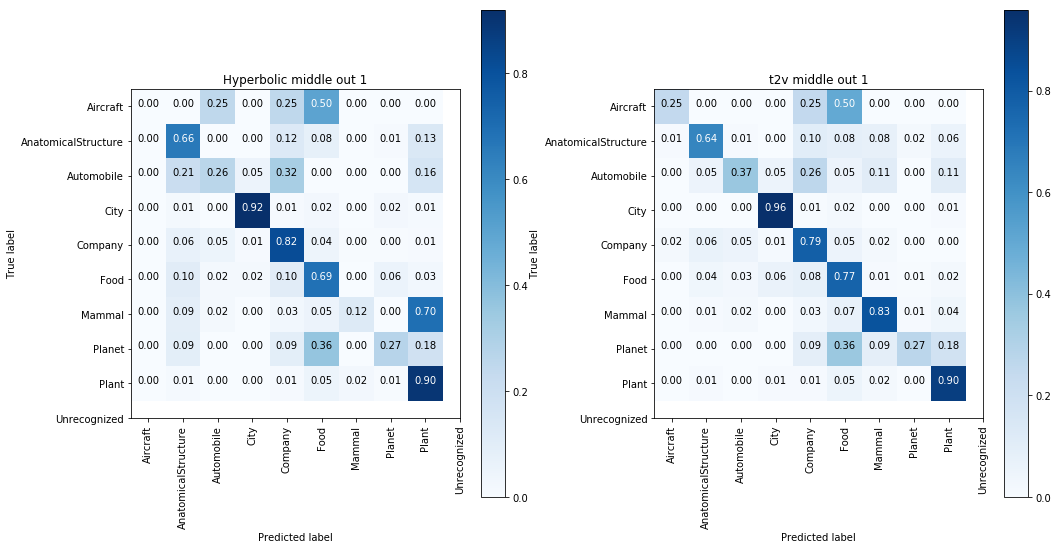

In [53]:
mo_y_predict = mo_mixed_model.predict(encoded_test)
res = check_prediction(labels=labels_test, 
                   vectors=mo_y_predict,
                   embedding=[embeddings['t2v'], embeddings['hyper']],
                   topn=10,
                   mode='both')


classes = [x.replace('dbo:', '') for x in types]
classes = classes + ['Unrecognized']
classes = sorted(classes)

plt.figure(figsize=(15, 15))
pred = res['hypLabel']
plt.subplot(221)
cnf_matrix = confusion_matrix(y_true = labels_test, y_pred = pred)
plot_confusion_matrix(cnf_matrix, classes = classes, title='Hyperbolic middle out 1')


plt.subplot(222)
pred = res['t2vLabel']
cnf_matrix = confusion_matrix(y_true = labels_test, y_pred = pred)
plot_confusion_matrix(cnf_matrix, classes = classes, title='t2v middle out 1')


In [33]:
def distance_from_cluster(vec, train_vector_types_dict):
    dist = [0 for i in train_vector_types_dict.keys()]
    for i, k in enumerate(train_vector_types_dict.keys()):
        d = cdist(np.array([vec]), 
                  train_vector_types_dict[k], 
                  cos_sim)
        m = np.nanmean(d)
        inds = np.where(np.isnan(d))
        d[inds] = m
        dist[i] = np.mean(d[0])
    return dist

In [167]:
encoded_train_vector_types_dict = {k: [] for k in classes}
for vec, clas in zip(encoded_train, labels_train):
    encoded_train_vector_types_dict[clas].append(vec)

In [168]:
words = ['limousine', 'Batmobile', 'Fiorino'
         ,'pizza', 'meatballs', 'juice'
         ,'pine', 'sunflower', 'stinkhorn'
         ,'Rome', 'Germany', 'Italy'
         ,'dog', 'cat', 'crab'
         ,'Olivetti', 'Yahoo', 'Harvard'
         ,'heart', 'carotid', 'tail'
         ,'Moon', 'sun', 'star']


for word in words:
#     print('Predictions for {}'.format(word))
    if word in all_words:
        print('Predictions for {} which is in train or in test dataset'.format(word))
    else:
        print('Predictions for {} which is NOT in train and NOT in test dataset'.format(word))

    vector = word_embedding[word]
    vector = mixed_encoder.predict(np.array([vector]))
    pred = mo_mixed_model.predict(np.array(vector))
    t2v_pred = pred[0][0]
    t2v_neigh = find_neighbours(vector=t2v_pred,
                               model=type_embedding,
                               mode='t2v',
                               topn=len(types))

    t2v_sim = t2v_neigh[0]
    t2v_label = t2v_neigh[1]

    t2v_sim = [round(x, 4) for x in t2v_sim]

    hyper_pred = pred[1][0]
    hyper_neigh = find_neighbours(vector=hyper_pred,
                                 model=hyperbolic_embedding, 
                                 mode='hyper',
                                 topn=len(types))


    hyper_sim = hyper_neigh[0]
    hyper_label = hyper_neigh[1]

    hyper_sim = [round(x, 4) for x in hyper_sim]

    mean_cluster_dist = distance_from_cluster(vector[0], encoded_train_vector_types_dict)
    mcd = list(zip(mean_cluster_dist, classes))
    mcd = sorted([[y, x] for x, y in mcd], key=itemgetter(1), reverse=True)

    mcd_label = [y for y, x in mcd]
    mcd_sim = [x for y, x in mcd]

    n = 5

    print('-----------------------------------------------------------------------------------------------------------')
    print('Mean Cluster Similarity            |T2V PREDICTION              cos-sim|HYPER PREDICTION            hyper-d')
    print('-----------------------------------|-----------------------------------|-----------------------------------')
    for x, y, w, z, ml, ms in zip(hyper_label[:n], hyper_sim[:n], t2v_label[:n], t2v_sim[:n], mcd_label[:n], mcd_sim[:n]):
        print('{:25} {:9.4f}|{:25} {:9.4f}|{:25} {:9.4f}'.format(ml, ms, w, z, x, y)) 
    print('-----------------------------------------------------------------------------------------------------------')

Predictions for limousine which is in train or in test dataset
-----------------------------------------------------------------------------------------------------------
Mean Cluster Similarity            |T2V PREDICTION              cos-sim|HYPER PREDICTION            hyper-d
-----------------------------------|-----------------------------------|-----------------------------------
Automobile                   0.7355|Automobile                   0.9994|NaturalEvent                    nan
Aircraft                     0.3589|AutomobileEngine             0.6555|Earthquake                      nan
Company                      0.2867|Motorcycle                   0.5928|SolarEclipse                    nan
AnatomicalStructure          0.1107|InformationAppliance         0.5913|StormSurge                      nan
Mammal                       0.0742|RacingDriver                 0.5773|Province                        nan
-------------------------------------------------------------------------

# TO DO: plot dei cluster